https://pypi.org/project/wittgenstein/

https://github.com/imoscovitz/wittgenstein

http://webcache.googleusercontent.com/search?q=cache:https://medium.com/swlh/the-ripper-algorithm-a5eebbe3661d&strip=0&vwsrc=1&referer=medium-parser

This notebook uses `wittgenstein`, which is a library that implements a decision tree to retrieve feature rules to forecast the target.

References: 
- https://colab.research.google.com/drive/1ww42E4mATATR5URTxLv6Ujsla7O90i_e?usp=sharing#scrollTo=VrcNFkMtEi2u
- https://twitter.com/jantolip/status/1720418319327486050?t=GNNFYGiTAleo6OnkIGCYrg

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
import wittgenstein as lw
import yfinance as yf
# 
from scipy.stats import ks_2samp

In [2]:
# globals
start_train = '2006-01-01'
start_train = pd.to_datetime(start_train)
end_train = '2020-01-01'
end_train = pd.to_datetime(end_train)
start_test = '2020-01-01'
start_test = pd.to_datetime(start_test)
end_test = '2022-01-01'
end_test = pd.to_datetime(end_test)
start_forward = '2022-01-01'
start_forward = pd.to_datetime(start_forward)
end_forward = '2024-01-01'
end_forward = pd.to_datetime(end_forward)
# parameters
ticker = 'MSFT'
random_state = 42
max_rules = 3
random_columns = 10
top_rules_combo = 10
sqn_threshold = 1.5
len_test_trades = 10

In [3]:
# functions
def get_data(ticker,start_train,end_oos):
    data = yf.download(ticker, start=start_train, end=end_oos)
    data = data.drop(columns=['Close','Volume'], axis=1)
    data = data.rename(columns={'Adj Close': 'Close'})
    data.columns = ["Open", "High", "Low", "Close"]

    return data

def get_returns(data):
    data['Return'] = (data['Open'].shift(-2) - data['Open'].shift(-1))
    return data

def get_indicators(data):

    #Extraer columnas necesarias para el cálculo de indicadores
    close = data["Close"]
    high = data["High"]
    low = data["Low"]

    #Crear de listas para guardar el nombre de los indicadores y los valores
    indicators = []
    columns = []

    #CCI - Commodity Channel Index
    for n in np.arange(2,100):
        name = "CCI" + str(n)
        indicators.append(ta.cci(high, low, close, n))
        columns.append(name)
    #NORMALIZED AVERANGE TRUE RANGE
    for n in np.arange(2,100):
        name = "NATR" + str(n)
        indicators.append(ta.natr(high, low, close, n))
        columns.append(name)
    #RSI - Relative Strength Index
    for n in np.arange(2,100):
        name = "RSI" + str(n)
        indicators.append(ta.rsi(close, n))
        columns.append(name)
    #WILLR - Williams' %R
    for n in np.arange(2,100):
        name = "WILLR" + str(n)
        indicators.append(ta.willr(high, low, close, n))
        columns.append(name)
    #ADX
    for n in np.arange(2,100):
        adx = ta.adx(high, low, close, n)
        name = "ADX" + str(n)
        indicators.append(adx["ADX_"+str(n)])
        columns.append(name)
    #DMP
    for n in np.arange(2,100):
        adx = ta.adx(high, low, close, n)
        name = "DMP" + str(n)
        indicators.append(adx["DMP_"+str(n)])
        columns.append(name)
    #DMN
    for n in np.arange(2,100):
        adx = ta.adx(high, low, close, n)
        name = "DMN" + str(n)
        indicators.append(adx["DMN_"+str(n)])
        columns.append(name)
    #MOMENTUM
    for n in np.arange(2,100):
        name = "MOM" + str(n)
        indicators.append(ta.mom(close, n))
        columns.append(name)

    #Crear dataframe con todos los indicadores calculados
    df = pd.concat(indicators, axis=1)
    df.columns = columns
    df.index = data.index
    df["Open"] = data["Open"]
    df['High'] = data['High']
    df['Low'] = data['Low']
    df['Close'] = data['Close']

    #Eliminar las filas con valores faltantes
    df = df.dropna()

    return df

def get_dataset(ticker,start_train,end_oos):
    # Obtener el histórico
    data = get_data(ticker,start_train,end_oos)
    # Calcular indicadores
    data = get_indicators(data)
    # Calcular retorno a 1 día vista
    data = get_returns(data)
    data['Return'] = data['Return']
    # Obtener etiquetado
    data['Label'] = np.where(data['Return'] > 0, 1, 0)
    # Limpiar dataset
    data = data.drop(['High', 'Low'], axis=1)
    data = data.dropna()

    return data

def get_sampling(data,start_train,end_train,start_test, end_test):
    '''
    This function retrieves a sample of the train data that is most likely associated with the OOS data.
    It compares the returns in sample and oos and retrieves a sample that is most similar between the two sets.
    This sample can be used for the training.
    '''
    in_sample = data.loc[start_train:end_train]
    oos = data.loc[start_test:end_test]

    date_inicial = []
    date_final = []
    p = []
    inicio = -1
    final = len(oos)-1
    while final < len(in_sample):
        inicio += 1
        final += 1
        sample = in_sample.iloc[inicio:final]
        date_inicial.append(sample.index[1])
        date_final.append(sample.index[-1])
        p.append(ks_2samp(sample['Return'], oos['Return']).pvalue)

    df = pd.DataFrame({'Inicio': date_inicial,
                        'Final': date_final,
                        'P': p})

    df = df.sort_values('P', ascending=False).head(50)
    df = df.sort_values('Inicio', ascending=True)
    inicio = list(df['Inicio'])[0]
    final = list(df['Final'])[-1]
    sample = data.loc[inicio:final]

    return sample

In [4]:
# get data
data = get_dataset(ticker,start_train,end_forward)
data

[*********************100%%**********************]  1 of 1 completed


,CCI2,CCI3,CCI4,CCI5,CCI6,CCI7,CCI8,CCI9,CCI10,CCI11,...,MOM94,MOM95,MOM96,MOM97,MOM98,MOM99,Open,Close,Return,Label
Date,,,,,,,,,,,,,,,,,,,,,
2006-10-13,66.666667,100.000000,115.008174,138.779021,165.296874,179.982324,198.007369,195.274184,195.484319,192.543135,...,4.030766,4.151947,3.795528,3.389202,3.374945,3.546028,28.340000,20.297905,-0.240000,0
2006-10-16,-66.666667,49.247230,66.215322,82.894685,97.431095,111.669748,127.399592,139.406411,142.890972,147.592397,...,4.130779,4.088009,4.209190,3.852772,3.446445,3.432188,28.480000,20.355148,0.260000,1
2006-10-17,-66.666667,-100.000000,18.043425,41.971231,54.539247,65.217526,75.351691,85.035928,93.874443,100.271832,...,4.308958,4.123613,4.080843,4.202024,3.845606,3.439280,28.240000,20.347982,-0.150000,0
2006-10-18,66.666667,70.207386,74.761268,62.297644,59.894676,66.695763,74.975179,83.671438,92.673941,101.261206,...,4.629945,4.366199,4.180855,4.138084,4.259266,3.902847,28.500000,20.405224,0.129999,1
2006-10-19,-66.666667,-86.551344,-102.361914,-121.368114,-28.471572,14.307952,27.179278,34.803765,40.978217,46.151625,...,4.529554,4.465394,4.201649,4.016304,3.973534,4.094715,28.350000,20.240673,-0.180000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20,66.666667,75.204022,77.664502,73.743610,43.448661,34.288834,42.544135,40.961358,46.933054,52.184185,...,45.917908,41.874664,44.195038,45.310394,44.473877,35.670441,375.000000,370.619995,1.119995,1
2023-12-21,66.666667,99.593926,90.774586,76.842775,73.223609,49.818291,42.525805,49.791296,49.191564,54.644101,...,52.642090,48.837921,44.794678,47.115051,48.230408,47.393890,372.559998,373.540009,1.320007,1
2023-12-22,66.666667,100.000000,133.333333,156.135477,139.818276,116.353062,96.883469,96.240508,98.174954,103.187629,...,52.984985,53.682068,49.877899,45.834656,48.155029,49.270386,373.679993,374.579987,-1.309998,0


In [5]:
# train
# train = get_sampling(data, start_train, end_train, start_test, end_test)
train = data.loc[start_train:end_train, :]
train

,CCI2,CCI3,CCI4,CCI5,CCI6,CCI7,CCI8,CCI9,CCI10,CCI11,...,MOM94,MOM95,MOM96,MOM97,MOM98,MOM99,Open,Close,Return,Label
Date,,,,,,,,,,,,,,,,,,,,,
2006-10-13,66.666667,100.000000,115.008174,138.779021,165.296874,179.982324,198.007369,195.274184,195.484319,192.543135,...,4.030766,4.151947,3.795528,3.389202,3.374945,3.546028,28.340000,20.297905,-0.240000,0
2006-10-16,-66.666667,49.247230,66.215322,82.894685,97.431095,111.669748,127.399592,139.406411,142.890972,147.592397,...,4.130779,4.088009,4.209190,3.852772,3.446445,3.432188,28.480000,20.355148,0.260000,1
2006-10-17,-66.666667,-100.000000,18.043425,41.971231,54.539247,65.217526,75.351691,85.035928,93.874443,100.271832,...,4.308958,4.123613,4.080843,4.202024,3.845606,3.439280,28.240000,20.347982,-0.150000,0
2006-10-18,66.666667,70.207386,74.761268,62.297644,59.894676,66.695763,74.975179,83.671438,92.673941,101.261206,...,4.629945,4.366199,4.180855,4.138084,4.259266,3.902847,28.500000,20.405224,0.129999,1
2006-10-19,-66.666667,-86.551344,-102.361914,-121.368114,-28.471572,14.307952,27.179278,34.803765,40.978217,46.151625,...,4.529554,4.465394,4.201649,4.016304,3.973534,4.094715,28.350000,20.240673,-0.180000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-66.666667,-47.363598,39.710598,52.134301,63.348766,74.212083,85.432882,96.815537,102.619620,102.867715,...,21.681503,19.843719,18.714233,22.169647,22.734375,25.108208,157.479996,151.657333,1.889999,1
2019-12-26,66.666667,100.000000,133.333333,89.449274,82.009447,87.653892,96.789891,103.446424,109.130412,114.164471,...,20.234924,22.924606,21.086823,19.957336,23.412750,23.977478,157.559998,152.900436,-0.459991,0
2019-12-27,66.666667,91.098938,106.551986,123.561752,119.809244,100.108261,100.271664,106.540776,109.788482,112.031673,...,24.509552,20.514420,23.204102,21.366318,20.236832,23.692245,159.449997,153.179932,-2.220001,0


In [6]:
#FEATURES
X = train.iloc[:,:-4]
X

,CCI2,CCI3,CCI4,CCI5,CCI6,CCI7,CCI8,CCI9,CCI10,CCI11,...,MOM90,MOM91,MOM92,MOM93,MOM94,MOM95,MOM96,MOM97,MOM98,MOM99
Date,,,,,,,,,,,,,,,,,,,,,
2006-10-13,66.666667,100.000000,115.008174,138.779021,165.296874,179.982324,198.007369,195.274184,195.484319,192.543135,...,4.586786,4.522626,4.258881,4.073536,4.030766,4.151947,3.795528,3.389202,3.374945,3.546028
2006-10-16,-66.666667,49.247230,66.215322,82.894685,97.431095,111.669748,127.399592,139.406411,142.890972,147.592397,...,4.594131,4.644030,4.579869,4.316124,4.130779,4.088009,4.209190,3.852772,3.446445,3.432188
2006-10-17,-66.666667,-100.000000,18.043425,41.971231,54.539247,65.217526,75.351691,85.035928,93.874443,100.271832,...,4.722397,4.586966,4.636864,4.572703,4.308958,4.123613,4.080843,4.202024,3.845606,3.439280
2006-10-18,66.666667,70.207386,74.761268,62.297644,59.894676,66.695763,74.975179,83.671438,92.673941,101.261206,...,4.929345,4.779638,4.644207,4.694105,4.629945,4.366199,4.180855,4.138084,4.259266,3.902847
2006-10-19,-66.666667,-86.551344,-102.361914,-121.368114,-28.471572,14.307952,27.179278,34.803765,40.978217,46.151625,...,4.907361,4.764794,4.615088,4.479656,4.529554,4.465394,4.201649,4.016304,3.973534,4.094715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-66.666667,-47.363598,39.710598,52.134301,63.348766,74.212083,85.432882,96.815537,102.619620,102.867715,...,20.922134,23.275040,22.986954,18.991821,21.681503,19.843719,18.714233,22.169647,22.734375,25.108208
2019-12-26,66.666667,100.000000,133.333333,89.449274,82.009447,87.653892,96.789891,103.446424,109.130412,114.164471,...,19.975616,22.165237,24.518143,24.230057,20.234924,22.924606,21.086823,19.957336,23.412750,23.977478
2019-12-27,66.666667,91.098938,106.551986,123.561752,119.809244,100.108261,100.271664,106.540776,109.788482,112.031673,...,21.359543,20.255112,22.444733,24.797638,24.509552,20.514420,23.204102,21.366318,20.236832,23.692245


In [7]:
#LABEL
Y = train['Label']
Y

Date
2006-10-13    0
2006-10-16    1
2006-10-17    0
2006-10-18    1
2006-10-19    0
             ..
2019-12-24    1
2019-12-26    0
2019-12-27    0
2019-12-30    1
2019-12-31    0
Name: Label, Length: 3326, dtype: int32

In [8]:
# test
test = data.loc[start_test:end_test, :]
test

,CCI2,CCI3,CCI4,CCI5,CCI6,CCI7,CCI8,CCI9,CCI10,CCI11,...,MOM94,MOM95,MOM96,MOM97,MOM98,MOM99,Open,Close,Return,Label
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,66.666667,100.000000,101.710927,125.259966,142.494449,156.561763,169.846118,165.389661,154.580910,142.234806,...,21.854706,24.044327,26.397232,26.109146,22.114014,24.803696,158.779999,154.779526,-1.240005,0
2020-01-03,-66.666667,13.780903,30.268333,27.097306,34.803909,47.252665,57.174911,65.552549,75.693782,81.216867,...,21.031845,19.927414,22.117035,24.469940,24.181854,20.186722,158.320007,152.852234,2.240005,1
2020-01-06,-66.666667,-87.782743,-29.785737,-17.753177,-26.465250,-26.167467,-12.396256,-4.515505,4.087957,24.951810,...,19.957611,21.426971,20.322540,22.512161,24.865067,24.576981,157.080002,153.247360,-0.390015,0
2020-01-07,-66.666667,-50.643391,-66.995473,-27.743823,-17.610105,-25.520408,-25.657227,-12.767250,-5.074694,3.487184,...,19.530289,18.560333,20.029694,18.925262,21.114883,23.467789,159.320007,151.850082,2.910004,1
2020-01-08,66.666667,100.000000,113.167261,68.753344,79.537944,90.671670,93.093470,103.281332,110.619101,119.275103,...,26.165024,21.948975,20.979019,22.448380,21.343948,23.533569,158.929993,154.268768,0.980011,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,66.666667,100.000000,105.399740,109.514276,117.753428,136.709213,141.589551,159.255799,123.505976,104.850713,...,52.755524,55.553619,56.052582,54.203491,53.097961,53.039246,335.459991,336.289185,-1.850006,0
2021-12-28,66.666667,69.973047,80.361129,93.109586,95.810735,104.887344,117.447032,128.300220,140.588971,119.222626,...,48.602875,51.577026,54.375122,54.874084,53.024994,51.919464,343.149994,335.110687,0.610016,1
2021-12-29,66.666667,57.591118,62.612184,66.633212,74.827501,80.707724,87.389082,97.084774,107.813458,117.616455,...,47.578369,49.290375,52.264526,55.062622,55.561584,53.712494,341.299988,335.798187,-3.399994,0


In [9]:
# forward
forward = data.loc[start_forward:end_forward, :]
forward

,CCI2,CCI3,CCI4,CCI5,CCI6,CCI7,CCI8,CCI9,CCI10,CCI11,...,MOM94,MOM95,MOM96,MOM97,MOM98,MOM99,Open,Close,Return,Label
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,-66.666667,-97.479680,-102.963800,-119.836685,-141.787626,-104.869089,-67.171511,-30.241194,-5.152838,7.218225,...,37.828979,43.749481,41.994873,40.507874,42.219879,45.194031,335.350006,328.727692,-8.970001,0
2022-01-04,-66.666667,-100.000000,-107.267089,-119.833533,-131.901569,-147.344513,-140.372029,-114.757520,-78.266621,-48.547411,...,24.752380,32.192200,38.112701,36.358093,34.871094,36.583099,334.829987,323.090912,-12.709991,0
2022-01-05,-66.666667,-100.000000,-131.798715,-142.550338,-158.425090,-170.211244,-185.847768,-202.435970,-198.689655,-172.101756,...,12.065308,12.349640,19.789459,25.709961,23.955353,22.468353,325.859985,310.688171,1.000000,1
2022-01-06,-66.666667,-77.649258,-87.931476,-103.261026,-119.588098,-131.732345,-143.125061,-156.670930,-173.412209,-180.017034,...,11.600159,9.610291,9.894623,17.334442,23.254944,21.500336,313.149994,308.233154,-4.660004,0
2022-01-07,-66.666667,-66.101885,-73.867993,-75.829828,-84.305763,-94.264396,-105.042191,-115.682076,-124.837311,-136.213474,...,12.355164,11.757263,9.767395,10.051727,17.491547,23.412048,314.149994,308.390259,3.890015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20,66.666667,75.204022,77.664502,73.743610,43.448661,34.288834,42.544135,40.961358,46.933054,52.184185,...,45.917908,41.874664,44.195038,45.310394,44.473877,35.670441,375.000000,370.619995,1.119995,1
2023-12-21,66.666667,99.593926,90.774586,76.842775,73.223609,49.818291,42.525805,49.791296,49.191564,54.644101,...,52.642090,48.837921,44.794678,47.115051,48.230408,47.393890,372.559998,373.540009,1.320007,1
2023-12-22,66.666667,100.000000,133.333333,156.135477,139.818276,116.353062,96.883469,96.240508,98.174954,103.187629,...,52.984985,53.682068,49.877899,45.834656,48.155029,49.270386,373.679993,374.579987,-1.309998,0


In [10]:
# TA Rules
rules_list = []
sqn_train_list = []
sqn_test_list = []
sqn_forward_list = []
#Crear bucle para la obtención de las N reglas a base de árboles de decisión
while len(rules_list) < top_rules_combo:
    #Obtener reglas con ripper
    ripper_clf = lw.RIPPER(max_rules=max_rules)
    ripper_clf.fit(X.sample(random_columns, axis=1), Y)
    rule = str(ripper_clf.ruleset_[0])
    #Calcular resultados en el train
    train_bt = train.copy()
    train_bt['pred'] = ripper_clf.predict(train_bt)
    train_trades = train_bt[train_bt['pred']==True]['Return']
    sqn_train = (train_trades.mean()/train_trades.std())*len(train_trades)**0.5
    #Calcular resultados en el test
    test_bt = test.copy()
    test_bt['pred'] = ripper_clf.predict(test_bt)
    test_trades = test_bt[test_bt['pred']==True]['Return']
    sqn_test = (test_trades.mean()/test_trades.std())*len(test_trades)**0.5
    #Almacenar reglas filtradas y sus resultados en train, test y forward
    cond_1 = (sqn_test > sqn_train)
    cond_2 = (sqn_train > sqn_threshold)
    cond_3 = (len(test_trades) > len_test_trades)
    # print("Conditions: ", cond_1,cond_2,cond_3)
    if cond_1 & cond_2 & cond_3 & (sqn_train not in sqn_train_list):
        rules_list.append(rule)
        sqn_train_list.append(sqn_train)
        sqn_test_list.append(sqn_test)
        #Calcular resultados en el forward
        forward_bt = forward.copy()
        forward_bt['pred'] = ripper_clf.predict(forward_bt)
        forward_trades = forward_bt[forward_bt['pred']==True]['Return']
        sqn_forward = (forward_trades.mean()/forward_trades.std())*len(forward_trades)**0.5
        sqn_forward_list.append(sqn_forward)
        print(rule, sqn_train, sqn_test, sqn_forward)

#DATAFRAME CON LOS RESULTADOS
df_ripper = pd.DataFrame({'Rule': rules_list, 'SQN_TRAIN': sqn_train_list, 'SQN_TEST':sqn_test_list, 'SQN_FORWARD': sqn_forward_list})
df_ripper = df_ripper.fillna(0)

[ADX98=8.21-9.16] 1.759098129127111 3.0697484027584245 0.9400999413552282
[CCI23=<-122.14] 2.856897072592251 3.2503263392120605 1.207298608665228
[DMN82=>5.87] 1.9135272126972063 2.08758105282751 0.3415523896266076
[DMP8=5.17-7.55] 2.2461704259743858 3.6400973312718685 0.24449065519130767
[CCI24=<-122.14] 2.995179398454982 3.0494582359304077 1.3774352027483479
[DMN30=>6.0] 1.9442231335168103 1.9556133663234967 0.3415523896266076
[DMN55=>6.05^DMP8=5.17-7.55] 1.8074980746777332 3.6400973312718685 0.24449065519130767
[MOM26=<-2.04] 3.190125776759708 3.722508308602468 -0.013534916969980892
[ADX51=7.66-8.95] 2.4149396118904822 2.571084272338761 0.586219214737675
[DMN64=>6.06^WILLR45=-115.12--93.2^CCI92=-17.26-30.18] 2.461579809454795 2.9809398971804786 -0.6197687920331371


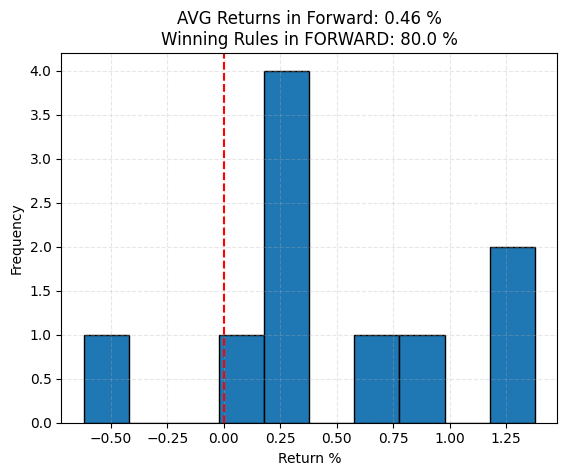

In [14]:
# forward results

#PORCENTAJE DE REGLAS GANADORAS EN FORWARD
count = 0
for sqn in df_ripper['SQN_FORWARD']:
    if sqn > 0:
        count +=1
perc = count*100/len(df_ripper['SQN_FORWARD'])

#DISTRIBUCIÓN DE RESULTADOS EN FORWARD
plt.hist(df_ripper['SQN_FORWARD'], bins=10, edgecolor='black')
media = round(df_ripper['SQN_FORWARD'].mean(),2)
media_ = 'AVG Returns in Forward: ' + str(media) + ' %'
porcentaje = round(perc,2)
porcentaje_ = '\nWinning Rules in FORWARD: ' + str(porcentaje) + ' %'
title = media_ + porcentaje_
plt.xlabel('Return %')
plt.ylabel('Frequency')
plt.title(title)
plt.axvline(x=0, color='red', linestyle='--')
plt.grid(True,alpha=0.3,linestyle='--')
plt.show()

In [12]:
# Top Rules
df_ripper

,Rule,SQN_TRAIN,SQN_TEST,SQN_FORWARD
0,[ADX98=8.21-9.16],1.759098,3.069748,0.940100
1,[CCI23=<-122.14],2.856897,3.250326,1.207299
2,[DMN82=>5.87],1.913527,2.087581,0.341552
3,[DMP8=5.17-7.55],2.246170,3.640097,0.244491
4,[CCI24=<-122.14],2.995179,3.049458,1.377435
5,[DMN30=>6.0],1.944223,1.955613,0.341552
6,[DMN55=>6.05^DMP8=5.17-7.55],1.807498,3.640097,0.244491
7,[MOM26=<-2.04],3.190126,3.722508,-0.013535
8,[ADX51=7.66-8.95],2.414940,2.571084,0.586219
9,[DMN64=>6.06^WILLR45=-115.12--93.2^CCI92=-17.2...,2.461580,2.980940,-0.619769
